## Set-Up

In [1]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import torch
from datasets import Dataset
import matplotlib.pyplot as plt
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/Colab Notebooks/Child_Mind_Institute_ML/'
df = pd.read_csv(path + 'merged_with_age_group.csv')
data_dictionary = pd.read_csv(path + 'data_dictionary.csv')

In [5]:
df.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,light_h7,light_h8,light_h9,light_w1,light_w2,light_w3,light_w4,light_w5,light_w6,light_w7
0,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,26.282324,17.601913,13.703326,15.487296,79.802590,30.175367,25.983143,33.926468,11.132876,87.537865
1,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.5,112.2,...,10.422992,25.086334,57.522930,9.958206,46.146200,14.388186,49.012680,39.446934,20.296366,5.850941
2,00f332d1,Winter,14,0,Spring,68.0,Spring,17.168636,66.5,108.0,...,26.846174,76.894750,108.581990,40.313942,45.987415,50.706913,41.632717,40.377525,228.700360,17.050716
3,01085eb3,Fall,12,0,Winter,58.0,Fall,34.187282,60.5,178.0,...,11.770081,17.703312,25.183878,22.056694,21.379330,15.844161,17.851442,12.499741,12.259155,26.816135
4,012cadd8,Spring,9,0,Winter,60.0,Fall,17.089151,53.2,68.8,...,10.299354,25.684927,34.599117,14.140425,48.232033,5.000000,74.605260,114.416660,77.441864,21.184536


In [6]:
data_dictionary.head()
data_dict = dict(zip(data_dictionary['Field'], data_dictionary['Description']))
data_dict

{'id': "Participant's ID",
 'Basic_Demos-Enroll_Season': 'Season of enrollment',
 'Basic_Demos-Age': 'Age of participant',
 'Basic_Demos-Sex': 'Sex of participant',
 'CGAS-Season': 'Season of participation',
 'CGAS-CGAS_Score': "Children's Global Assessment Scale Score",
 'Physical-Season': 'Season of participation',
 'Physical-BMI': 'Body Mass Index (kg/m^2)',
 'Physical-Height': 'Height (in)',
 'Physical-Weight': 'Weight (lbs)',
 'Physical-Waist_Circumference': 'Waist circumference (in)',
 'Physical-Diastolic_BP': 'Diastolic BP (mmHg)',
 'Physical-HeartRate': 'Heart rate (beats/min)',
 'Physical-Systolic_BP': 'Systolic BP (mmHg)',
 'Fitness_Endurance-Season': 'Season of participation',
 'Fitness_Endurance-Max_Stage': 'Maximum stage reached',
 'Fitness_Endurance-Time_Mins': 'Exact time completed: Minutes',
 'Fitness_Endurance-Time_Sec': 'Exact time completed: Seconds',
 'FGC-Season': 'Season of participation',
 'FGC-FGC_CU': 'Curl up total',
 'FGC-FGC_CU_Zone': 'Curl up fitness zone',

## Configuring Data

In [7]:
numerical_features = [col for col in df.columns if df[col].dtype in ['float64', 'int64'] and col not in ['id', '', 'sii', 'sii_2', 'age_group']]
categorical_features = ['Basic_Demos-Sex', 'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'age_group']

In [8]:
X = df.drop(['id', 'sii', 'sii_2'], axis=1)
sii_y = df['sii']
sii_2_y = df['sii_2']

X.shape, sii_y.shape, sii_2_y.shape

((977, 143), (977,), (977,))

In [9]:
y = sii_2_y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
def convert_to_dataset(X, y):
    # Convert features to text format
    texts = []
    for _, row in X.iterrows():
      text = ''
      for col, val in row.items():
        if col not in data_dict:
          text += f"{col}: {val}\n"
        else:
          text += f"{data_dict[col]}: {val}\n"
      text += 'Addicted to Internet:'
      texts.append(text)

    # y = y.map(lambda x: f'Addicted to Internet: {True if x==1 else False}')

    # Create dictionary for Dataset
    dataset_dict = {
        "text": texts,
        "label": y.tolist()
    }

    return Dataset.from_dict(dataset_dict)

In [11]:
train_dataset = convert_to_dataset(X_train, y_train.astype(int))
test_dataset = convert_to_dataset(X_test, y_test.astype(int))

In [12]:
train_dataset[0]

{'text': 'Season of enrollment: Winter\nAge of participant: 9\nSex of participant: 0\nSeason of participation: Spring\nChildren\'s Global Assessment Scale Score: 65.0\nSeason of participation: Winter\nBody Mass Index (kg/m^2): 16.94732143\nHeight (in): 56.0\nWeight (lbs): 75.6\nWaist circumference (in): nan\nDiastolic BP (mmHg): 63.0\nHeart rate (beats/min): 78.0\nSystolic BP (mmHg): 106.0\nSeason of participation: Winter\nMaximum stage reached: 2.0\nExact time completed: Minutes: 2.0\nExact time completed: Seconds: 9.0\nSeason of participation: Winter\nCurl up total: 0.0\nCurl up fitness zone: 0.0\nGrip Strength total (non-dominant): nan\nGrip Strength fitness zone (non-dominant): nan\nGrip Strength total (dominant): nan\nGrip Strength fitness zone (dominant): nan\nPush-up total: 5.0\nPush-up fitness zone: 0.0\nSit & Reach total (left side): 6.0\nSit & Reach fitness zone (left side): 0.0\nSit & Reach total (right side): 4.5\nSit & Reach fitness zone (right side): 0.0\nTrunk lift total

## Training

In [13]:
model_name = "bert-base-uncased"  # You can change to a different model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(y.unique()))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [15]:
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/781 [00:00<?, ? examples/s]

Map:   0%|          | 0/196 [00:00<?, ? examples/s]

In [16]:
tokenized_train[0]['input_ids'][0:20]

[101,
 2161,
 1997,
 10316,
 1024,
 3467,
 2287,
 1997,
 13180,
 1024,
 1023,
 3348,
 1997,
 13180,
 1024,
 1014,
 2161,
 1997,
 6577,
 1024]

In [17]:
from sklearn.metrics import log_loss
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Calculate cross-entropy loss
    # Softmax the logits first
    softmax = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
    ce_loss = log_loss(labels, softmax)

    return {
        "cross_entropy": ce_loss,
        "accuracy": (predictions == labels).astype(np.float32).mean().item()
    }

# Update training arguments
training_args = TrainingArguments(
    output_dir="./checkpoints_raw",
    save_strategy="epoch",
    eval_strategy="epoch",
    metric_for_best_model="cross_entropy",
    greater_is_better=False,
    load_best_model_at_end=True,
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    warmup_steps=500,
    logging_dir='./logs_raw',
    logging_strategy="steps",  # Log at each step
    logging_steps=10,         # Log every 10 steps
    logging_first_step=True   # Log the first step
)

In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: agnidipto (agnidipto-university-of-illinois-chicago) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Cross Entropy,Accuracy
1,0.674000,0.688337,0.688337,0.581633
2,0.677700,0.676773,0.676774,0.581633
3,0.676400,0.671606,0.671606,0.581633
4,0.547700,0.470967,0.470967,0.831633
5,0.392500,0.393024,0.393024,0.836735
6,0.344800,0.601523,0.601523,0.775510
7,0.313800,0.386838,0.386838,0.841837
8,0.366000,0.395153,0.395153,0.816327
9,0.276000,0.461862,0.461862,0.831633
10,0.390300,0.472906,0.472906,0.770408


TrainOutput(global_step=490, training_loss=0.49121713759947794, metrics={'train_runtime': 1075.6264, 'train_samples_per_second': 7.261, 'train_steps_per_second': 0.456, 'total_flos': 2054897342361600.0, 'train_loss': 0.49121713759947794, 'epoch': 10.0})

In [19]:
model.save_pretrained("./saved_model_raw")
tokenizer.save_pretrained("./saved_model_raw")

('./saved_model_raw/tokenizer_config.json',
 './saved_model_raw/special_tokens_map.json',
 './saved_model_raw/vocab.txt',
 './saved_model_raw/added_tokens.json',
 './saved_model_raw/tokenizer.json')

## Evluation

In [20]:
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

Evaluation results: {'eval_loss': 0.38683754205703735, 'eval_cross_entropy': 0.3868375907793308, 'eval_accuracy': 0.8418367505073547, 'eval_runtime': 5.8054, 'eval_samples_per_second': 33.762, 'eval_steps_per_second': 2.239, 'epoch': 10.0}


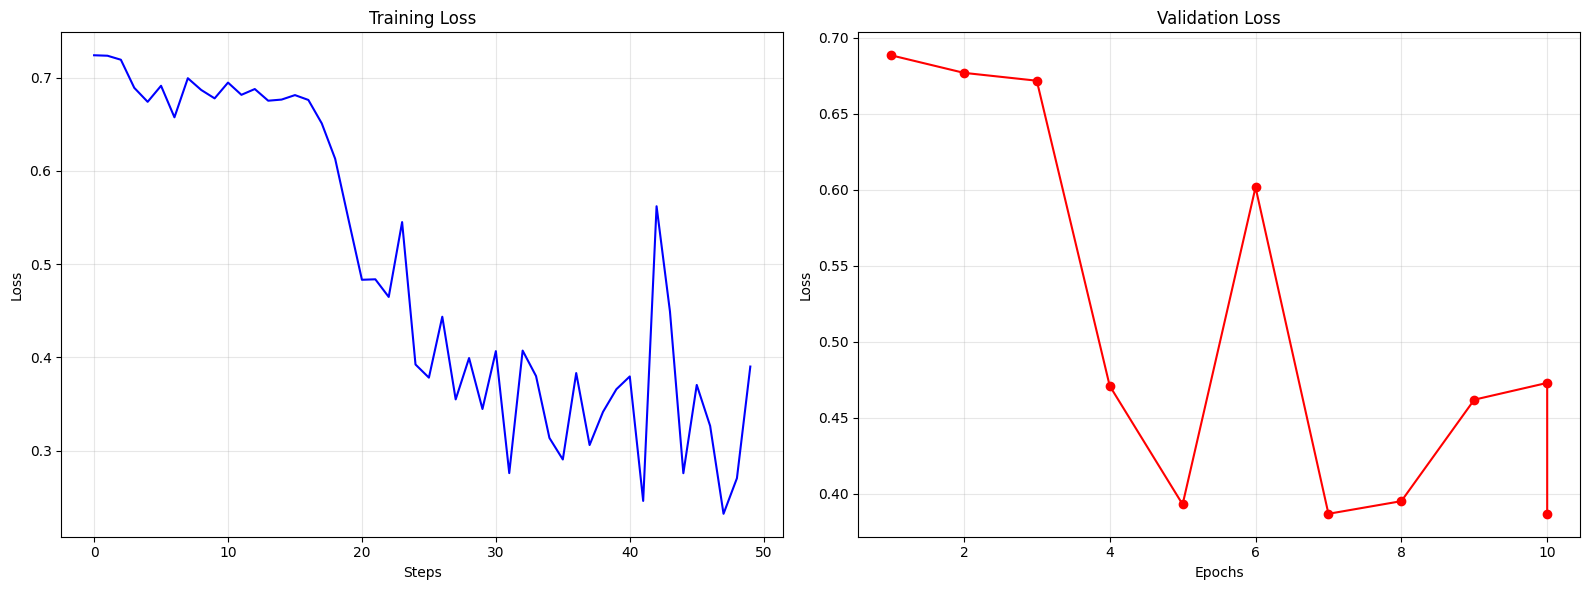

Final training loss: 0.49121713759947794


In [21]:
# Extract losses
training_logs = trainer.state.log_history
train_losses = []
eval_losses = []
eval_epochs = []

for log in training_logs:
    if 'loss' in log and 'eval_loss' not in log:
        train_losses.append(log['loss'])
    if 'eval_loss' in log:
        eval_losses.append(log['eval_loss'])
        if 'epoch' in log:
            eval_epochs.append(log['epoch'])

# Create a figure with two subplots side by side
plt.figure(figsize=(16, 6))

# Plot 1: Training Loss (if available)
plt.subplot(1, 2, 1)
if train_losses:
    plt.plot(range(len(train_losses)), train_losses, 'b-')
    plt.title('Training Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No training loss data available',
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes)

# Plot 2: Evaluation Loss
plt.subplot(1, 2, 2)
if eval_losses:
    if eval_epochs:
        plt.plot(eval_epochs, eval_losses, 'r-o')
        plt.xlabel('Epochs')
    else:
        plt.plot(range(len(eval_losses)), eval_losses, 'r-o')
        plt.xlabel('Evaluation Steps')
    plt.title('Validation Loss')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_validation_losses_raw.png')
plt.show()

# If there's a single final training loss
final_training_loss = next((log.get('train_loss') for log in reversed(training_logs) if 'train_loss' in log), None)
if final_training_loss:
    print(f"Final training loss: {final_training_loss}")

In [22]:
predictions = trainer.predict(tokenized_test)

# Extract predictions, labels, and metrics
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids
metrics = predictions.metrics

tokenized_test.shape

(196, 5)

In [23]:
metrics

{'test_loss': 0.38683754205703735,
 'test_cross_entropy': 0.3868375907793308,
 'test_accuracy': 0.8418367505073547,
 'test_runtime': 5.8038,
 'test_samples_per_second': 33.771,
 'test_steps_per_second': 2.24}

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(labels, preds)
print(f"Confusion Matrix:\n{conf_matrix}")

# Detailed classification report
class_report = classification_report(labels, preds)
print(f"Classification Report:\n{class_report}")

Confusion Matrix:
[[102  12]
 [ 19  63]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       114
           1       0.84      0.77      0.80        82

    accuracy                           0.84       196
   macro avg       0.84      0.83      0.84       196
weighted avg       0.84      0.84      0.84       196



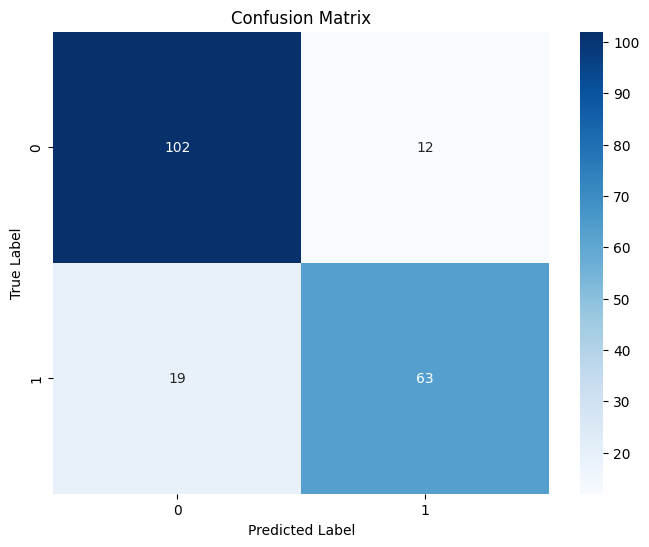

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_raw.png')
plt.show()

# Remove PCIAT Cols

In [26]:
pciat_cols = list(filter(lambda x: 'PCIAT' in x, list(df.columns)))
pciat_cols

['PCIAT-Season',
 'PCIAT-PCIAT_01',
 'PCIAT-PCIAT_02',
 'PCIAT-PCIAT_03',
 'PCIAT-PCIAT_04',
 'PCIAT-PCIAT_05',
 'PCIAT-PCIAT_06',
 'PCIAT-PCIAT_07',
 'PCIAT-PCIAT_08',
 'PCIAT-PCIAT_09',
 'PCIAT-PCIAT_10',
 'PCIAT-PCIAT_11',
 'PCIAT-PCIAT_12',
 'PCIAT-PCIAT_13',
 'PCIAT-PCIAT_14',
 'PCIAT-PCIAT_15',
 'PCIAT-PCIAT_16',
 'PCIAT-PCIAT_17',
 'PCIAT-PCIAT_18',
 'PCIAT-PCIAT_19',
 'PCIAT-PCIAT_20',
 'PCIAT-PCIAT_Total']

In [27]:
df_1 = df.drop(pciat_cols, axis=1)
df_1.shape

(977, 124)

In [28]:
X = df_1.drop(['id', 'sii', 'sii_2'], axis=1)
sii_y = df_1['sii']
sii_2_y = df_1['sii_2']

X.shape

(977, 121)

In [29]:
y = sii_2_y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
train_dataset = convert_to_dataset(X_train, y_train.astype(int))
test_dataset = convert_to_dataset(X_test, y_test.astype(int))

In [31]:
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/781 [00:00<?, ? examples/s]

Map:   0%|          | 0/196 [00:00<?, ? examples/s]

## Train

In [32]:
training_args = TrainingArguments(
    output_dir="./checkpoints_without_PCIAT",
    save_strategy="epoch",
    eval_strategy="epoch",
    metric_for_best_model="cross_entropy",
    greater_is_better=False,
    load_best_model_at_end=True,
    num_train_epochs=10,
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    warmup_steps=500,
    logging_dir='./logs_without_PCIAT',
    logging_strategy="steps",  # Log at each step
    logging_steps=10,         # Log every 10 steps
    logging_first_step=True   # Log the first step
)

In [33]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Cross Entropy,Accuracy
1,0.616000,0.672649,0.672649,0.658163
2,0.549500,0.687938,0.687938,0.653061
3,0.661200,0.643050,0.643050,0.647959
4,0.612500,0.672271,0.672271,0.653061
5,0.556500,0.729350,0.729350,0.637755
6,0.624800,0.657823,0.657823,0.632653
7,0.590000,0.653894,0.653894,0.642857
8,0.683500,0.644197,0.644197,0.658163
9,0.566000,0.771682,0.771682,0.637755
10,0.547300,0.802416,0.802416,0.612245


TrainOutput(global_step=490, training_loss=0.610402899858903, metrics={'train_runtime': 901.3174, 'train_samples_per_second': 8.665, 'train_steps_per_second': 0.544, 'total_flos': 2054897342361600.0, 'train_loss': 0.610402899858903, 'epoch': 10.0})

In [34]:
model.save_pretrained("./saved_model_without_PCIAT")
tokenizer.save_pretrained("./saved_model_without_PCIAT")

('./saved_model_without_PCIAT/tokenizer_config.json',
 './saved_model_without_PCIAT/special_tokens_map.json',
 './saved_model_without_PCIAT/vocab.txt',
 './saved_model_without_PCIAT/added_tokens.json',
 './saved_model_without_PCIAT/tokenizer.json')

In [35]:
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

Evaluation results: {'eval_loss': 0.6430497765541077, 'eval_cross_entropy': 0.6430498152984162, 'eval_accuracy': 0.6479591727256775, 'eval_runtime': 5.768, 'eval_samples_per_second': 33.981, 'eval_steps_per_second': 2.254, 'epoch': 10.0}


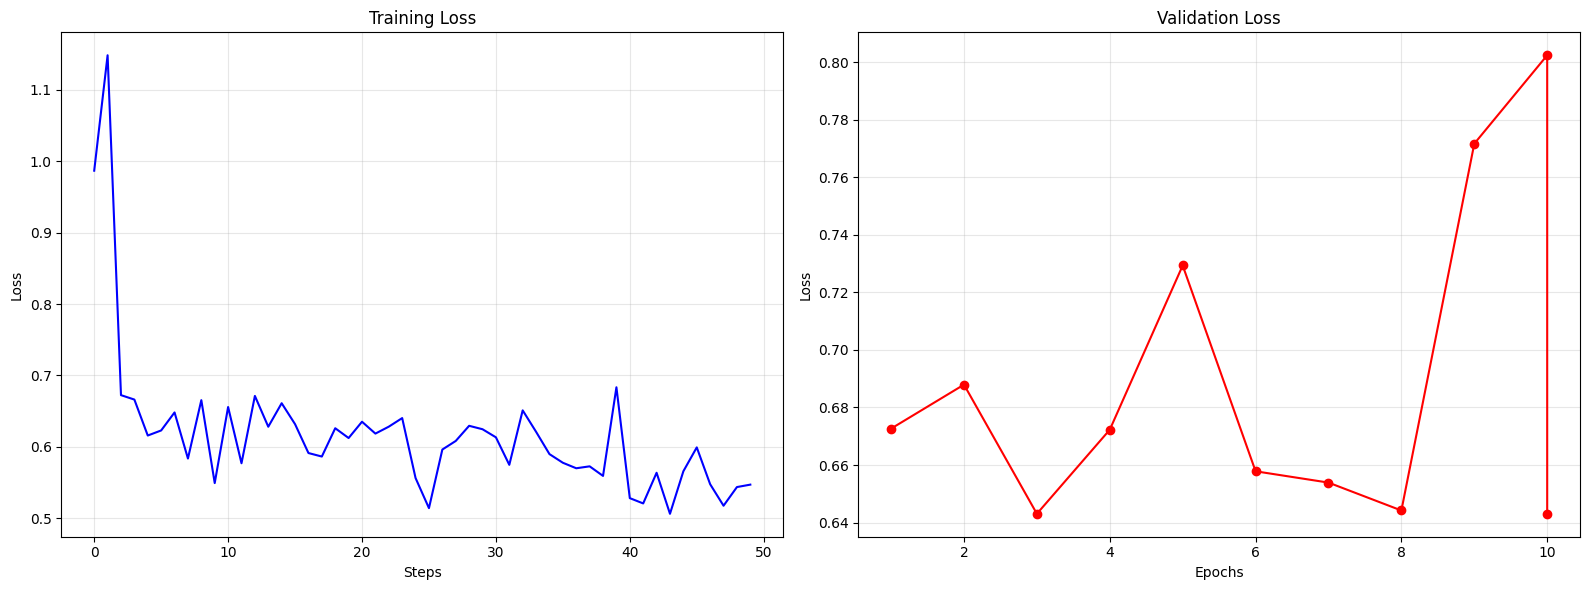

Final training loss: 0.610402899858903


In [36]:
# Extract losses
training_logs = trainer.state.log_history
train_losses = []
eval_losses = []
eval_epochs = []

for log in training_logs:
    if 'loss' in log and 'eval_loss' not in log:
        train_losses.append(log['loss'])
    if 'eval_loss' in log:
        eval_losses.append(log['eval_loss'])
        if 'epoch' in log:
            eval_epochs.append(log['epoch'])

# Create a figure with two subplots side by side
plt.figure(figsize=(16, 6))

# Plot 1: Training Loss (if available)
plt.subplot(1, 2, 1)
if train_losses:
    plt.plot(range(len(train_losses)), train_losses, 'b-')
    plt.title('Training Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No training loss data available',
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes)

# Plot 2: Evaluation Loss
plt.subplot(1, 2, 2)
if eval_losses:
    if eval_epochs:
        plt.plot(eval_epochs, eval_losses, 'r-o')
        plt.xlabel('Epochs')
    else:
        plt.plot(range(len(eval_losses)), eval_losses, 'r-o')
        plt.xlabel('Evaluation Steps')
    plt.title('Validation Loss')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_validation_losses_without_PCIAT.png')
plt.show()

# If there's a single final training loss
final_training_loss = next((log.get('train_loss') for log in reversed(training_logs) if 'train_loss' in log), None)
if final_training_loss:
    print(f"Final training loss: {final_training_loss}")

In [37]:
predictions = trainer.predict(tokenized_test)

# Extract predictions, labels, and metrics
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids
metrics = predictions.metrics

tokenized_test.shape

(196, 5)

In [38]:
from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(labels, preds)
print(f"Confusion Matrix:\n{conf_matrix}")

# Detailed classification report
class_report = classification_report(labels, preds)
print(f"Classification Report:\n{class_report}")

Confusion Matrix:
[[77 37]
 [32 50]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.68      0.69       114
           1       0.57      0.61      0.59        82

    accuracy                           0.65       196
   macro avg       0.64      0.64      0.64       196
weighted avg       0.65      0.65      0.65       196



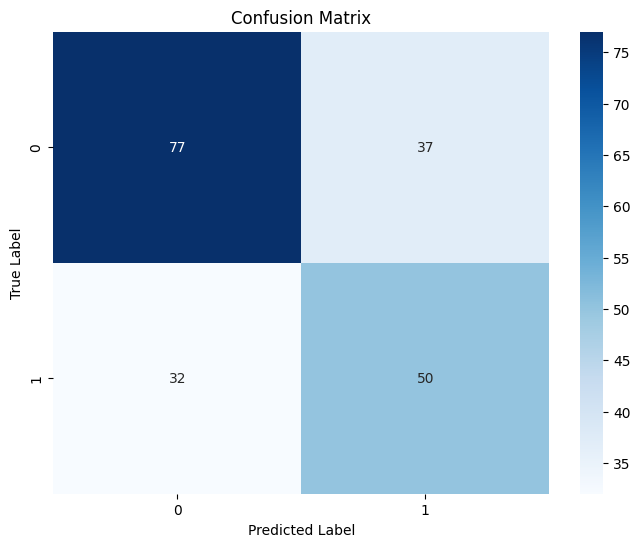

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_without_PCIAT.png')
plt.show()

In [42]:
import shutil
from google.colab import drive
import os

# Define source file and destination directory
destination_dir = '/content/drive/My Drive/Colab Notebooks/Child_Mind_Institute_ML/results'  # Replace with your folder
os.makedirs(destination_dir, exist_ok=True)

# To copy multiple files
files_to_copy = ['confusion_matrix_raw.png', 'confusion_matrix_without_PCIAT.png', 'training_validation_losses_raw.png', 'training_validation_losses_without_PCIAT.png']
for file in files_to_copy:
   if os.path.exists(file):
       shutil.copy(file, destination_dir)
       print(f"Copied {file} to {destination_dir}")
   else:
       print(f"File {file} not found")

# Define directories to copy
source_dirs = ['/content/checkpoints_raw',  '/content/checkpoints_without_PCIAT', '/content/logs_raw', '/content/logs_without_PCIAT', '/content/saved_model_raw', '/content/saved_model_without_PCIAT',
]

# Base destination in Google Drive
base_destination = '/content/drive/My Drive/Colab Notebooks/Child_Mind_Institute_ML/results'

# Create base destination if it doesn't exist
os.makedirs(base_destination, exist_ok=True)

# Copy each directory
for source_dir in source_dirs:
   if os.path.exists(source_dir):
       dest_dir = os.path.join(base_destination, os.path.basename(source_dir))
       shutil.copytree(source_dir, dest_dir, dirs_exist_ok=True)
       print(f"Copied {source_dir} to {dest_dir}")
   else:
       print(f"Directory {source_dir} not found")

Copied confusion_matrix_raw.png to /content/drive/My Drive/Colab Notebooks/Child_Mind_Institute_ML/results
Copied confusion_matrix_without_PCIAT.png to /content/drive/My Drive/Colab Notebooks/Child_Mind_Institute_ML/results
Copied training_validation_losses_raw.png to /content/drive/My Drive/Colab Notebooks/Child_Mind_Institute_ML/results
Copied training_validation_losses_without_PCIAT.png to /content/drive/My Drive/Colab Notebooks/Child_Mind_Institute_ML/results
Copied /content/checkpoints_raw to /content/drive/My Drive/Colab Notebooks/Child_Mind_Institute_ML/results/checkpoints_raw
Copied /content/checkpoints_without_PCIAT to /content/drive/My Drive/Colab Notebooks/Child_Mind_Institute_ML/results/checkpoints_without_PCIAT
Copied /content/logs_raw to /content/drive/My Drive/Colab Notebooks/Child_Mind_Institute_ML/results/logs_raw
Copied /content/logs_without_PCIAT to /content/drive/My Drive/Colab Notebooks/Child_Mind_Institute_ML/results/logs_without_PCIAT
Copied /content/saved_model_